## Import the Modules

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from collections import Counter
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow_hub as hub
from sklearn.linear_model import LogisticRegression
from seaborn import heatmap
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model,Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import (
    VGG16, DenseNet121, MobileNet, MobileNetV2
)
from tensorflow.keras.layers import Flatten, Dense,Resizing

from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

In [2]:
# Define constants
DATA_PATH = "radio bursts data"
IMG_SHAPE = (128, 128)
TEST_SPLIT = 0.2
NUM_CLASSES = 3
SEED = 42
os.makedirs('Weights', exist_ok=True)

In [3]:
# Utility Functions
def read_image(full_img_path):
    try:
        img = cv2.imread(full_img_path)
        return img
    except Exception as e:
        print(f"Warning: Error reading image '{full_img_path}': {e}")
        return None

In [4]:
def read_data(path, verbose=False, shape=IMG_SHAPE):
    images, labels, names = [], [], []
    for img_type in tqdm(os.listdir(path)):
        type_path = os.path.join(path, img_type)
        img_paths = [os.path.join(type_path, img) for img in os.listdir(type_path) if img.endswith('png')]

        with ThreadPoolExecutor() as executor:
            results = list(executor.map(read_image, img_paths))

        for img, img_path in zip(results, img_paths):
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image to RGB
                img = cv2.resize(img, shape)
                images.append(img)
                labels.append(img_type)
                names.append(img_path)

        if verbose:
            print(f'Finished reading {len(img_paths)} images of type "{img_type}".')

    return np.array(images), np.array(names), np.array(labels)

In [5]:
def preprocess_spectrogram(data):
    median_values = np.median(data, axis=0)
    return data - median_values

## Load and preprocess the dataset

In [6]:
# Load and preprocess data
images, paths, labels = read_data(DATA_PATH, verbose=False)
preprocessed_data = np.array([preprocess_spectrogram(img) for img in images])

100%|██████████| 3/3 [00:40<00:00, 13.42s/it]


Text(0, 0.5, 'Frequency')

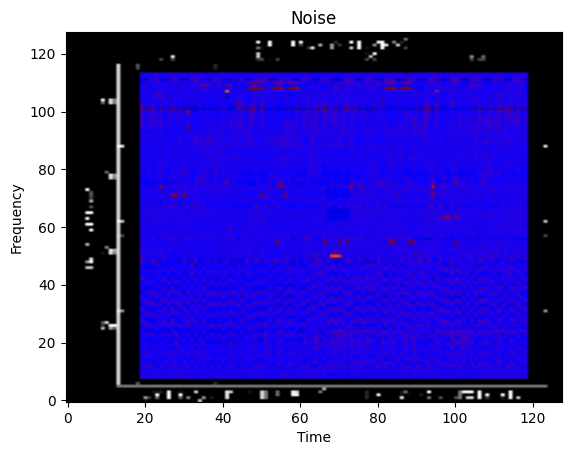

In [7]:
plt.imshow(images[1], aspect='auto', origin='lower')
plt.title('Noise')
plt.xlabel('Time')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

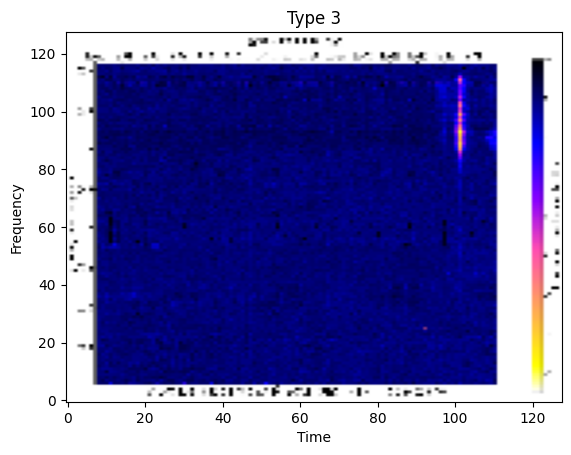

In [8]:
plt.imshow(images[-1], aspect='auto', origin='lower')
plt.title('Type 3')
plt.xlabel('Time')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

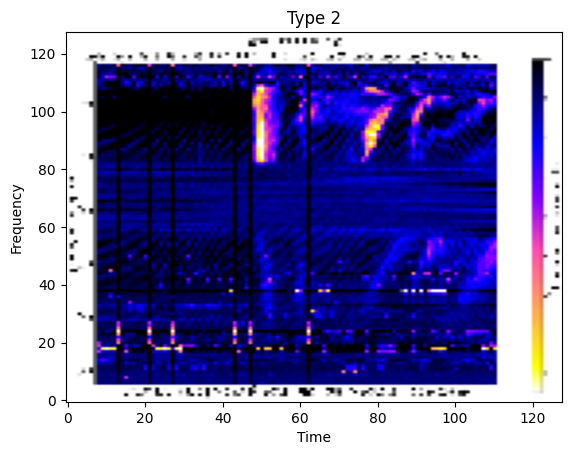

In [9]:
plt.imshow(images[700], aspect='auto', origin='lower')
plt.title('Type 2')
plt.xlabel('Time')
plt.ylabel('Frequency')

In [10]:
# Data Preparation
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, labels, test_size=TEST_SPLIT, random_state=SEED)
label_encoder = {label: idx for idx, label in enumerate(np.unique(y_train))}

In [11]:
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train_encoded = np.array([label_encoder[label] for label in y_train])
y_test_encoded = np.array([label_encoder[label] for label in y_test])

## Deep Learning

### Custome model

In [12]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [13]:
input_shape = X_train.shape[1:]  # Shape after preprocessing
cnn_model = create_cnn_model(input_shape, NUM_CLASSES)
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Train CNN Model
checkpoint = ModelCheckpoint('best_cnn_model.keras', monitor='val_accuracy', save_best_only=True)
cnn_model.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.4456 - loss: 1.1489 - val_accuracy: 0.6870 - val_loss: 0.7597
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 0.6870 - loss: 0.7337 - val_accuracy: 0.7590 - val_loss: 0.6670
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.7106 - loss: 0.6322 - val_accuracy: 0.7590 - val_loss: 0.6192
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.7471 - loss: 0.5629 - val_accuracy: 0.7784 - val_loss: 0.5331
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.7780 - loss: 0.4848 - val_accuracy: 0.8726 - val_loss: 0.3932
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.8466 - loss: 0.3765 - val_accuracy: 0.8643 - val_loss: 0.3731
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.8786 - loss: 0.3478 - val_accuracy: 0.8837 - val_loss: 0.3688
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.9018 - loss: 0.2795 - val_accuracy:

In [16]:
# Evaluate CNN Model
cnn_model = load_model('best_cnn_model.keras')
train_loss, train_accuracy = cnn_model.evaluate(X_train, y_train_encoded)
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test_encoded)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save model weights
cnn_model.save_weights('Weights\cnn_model.weights.h5')

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9873 - loss: 0.0417
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9215 - loss: 0.2982
Train Accuracy: 97.39%
Test Accuracy: 90.91%


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


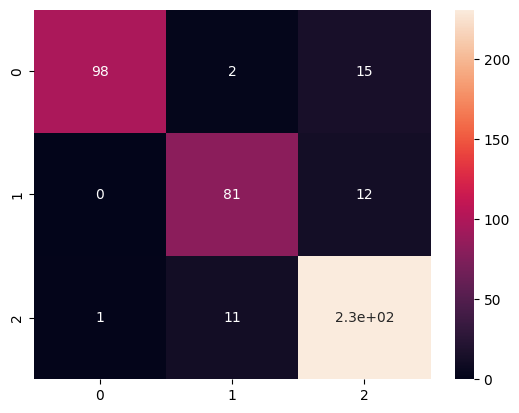

In [21]:
test_pred=cnn_model.predict(X_test)
sns.heatmap(confusion_matrix(y_test_encoded,np.argmax(test_pred,axis=1)),annot=True)
plt.show()

### Pretrained Models

In [22]:
# Pretrained Models Setup
pretrained_models = {
    'VGG16': VGG16,
    'DenseNet121': DenseNet121,
    'MobileNet': MobileNet,
    'MobileNetV2': MobileNetV2
}

In [23]:
# Transfer Learning Function
def create_pretrained_model(model_class, input_shape, num_classes):
    base_model = model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [24]:
# Cross-Validation with Pretrained Models
cv_results = {model_name: [] for model_name in pretrained_models.keys()}

for model_name, model_class in pretrained_models.items():
    print(f"Running K-Fold CV for {model_name}...")
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train_encoded[train_idx], y_train_encoded[val_idx]
        
        model = create_pretrained_model(model_class, input_shape, NUM_CLASSES)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        checkpoint = ModelCheckpoint(f'{model_name}_best.keras', monitor='val_accuracy', save_best_only=True)
        
        model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint])
        best_model = load_model(f'{model_name}_best.keras')
        _, accuracy = best_model.evaluate(X_val_fold, y_val_fold)
        cv_results[model_name].append(accuracy)

Running K-Fold CV for VGG16...
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 949ms/step - accuracy: 0.5642 - loss: 1.1372 - val_accuracy: 0.7562 - val_loss: 0.5636
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 42s 907ms/step - accuracy: 0.8091 - loss: 0.4987 - val_accuracy: 0.8476 - val_loss: 0.4251
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 43s 935ms/step - accuracy: 0.8253 - loss: 0.4731 - val_accuracy: 0.8144 - val_loss: 0.4270
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 46s 997ms/step - accuracy: 0.8399 - loss: 0.4097 - val_accuracy: 0.8864 - val_loss: 0.3637
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 44s 968ms/step - accuracy: 0.8994 - loss: 0.3114 - val_accuracy: 0.8532 - val_loss: 0.3864
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 979ms/step - accuracy: 0.8996 - loss: 0.2731 - val_accuracy: 0.8837 - val_loss: 0.3196
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 46s 994ms/step - accuracy: 0.8927 - loss: 0.2872 - val_accuracy: 0.8975 - val_loss: 0.3006
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 988ms/step - accuracy: 0

In [25]:
# Calculate mean and std for CV accuracies and save to CSV
cv_summary = {
    'Model': [],
    'CV Accuracy (mean ± std)': []
}

In [26]:
for model_name, accuracies in cv_results.items():
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    cv_summary['Model'].append(model_name)
    cv_summary['CV Accuracy (mean ± std)'].append(f"{mean_acc:.4f} ± {std_acc:.4f}")

In [27]:
cv_summary_df = pd.DataFrame(cv_summary)
cv_summary_df.to_csv('cv_summary.csv', index=False)

In [28]:
cv_summary_df

,Model,CV Accuracy (mean ± std)
0,VGG16,0.9179 ± 0.0119
1,DenseNet121,0.9134 ± 0.0122
2,MobileNet,0.9273 ± 0.0088
3,MobileNetV2,0.9079 ± 0.0094


In [29]:
# Save cross-validation results to CSV
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.to_csv('cv_results.csv', index=False)

### Ensembles

#### Voting

In [30]:
# Soft Voting Ensemble
def soft_voting_ensemble(models, X):
    predictions = [model.predict(X) for model in models.values()]
    avg_predictions = np.mean(predictions, axis=0)
    return np.argmax(avg_predictions, axis=1)

In [31]:
models = {name: load_model(f'{name}_best.keras') for name in pretrained_models.keys()}
ensemble_predictions = soft_voting_ensemble(models, X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 690ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 547ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step


In [32]:
ensemble_accuracy = accuracy_score(y_test_encoded, ensemble_predictions)
print(f"Ensemble Test Accuracy: {ensemble_accuracy * 100:.2f}%")

Ensemble Test Accuracy: 91.80%


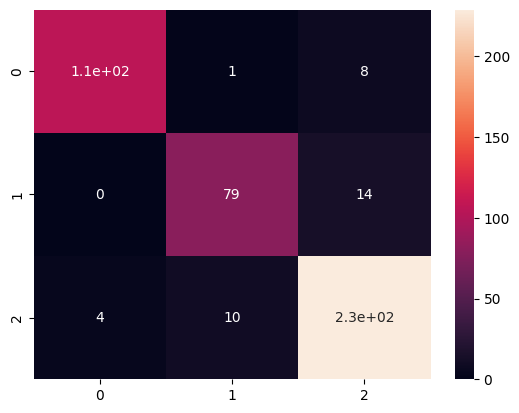

In [33]:
sns.heatmap(confusion_matrix(y_test_encoded,ensemble_predictions),annot=True)
plt.show()

#### Stacking

In [34]:
# Stacking Ensemble
def get_stacking_data(models, X):
    return np.hstack([model.predict(X) for model in models.values()])

In [35]:
stacking_train_data = get_stacking_data(models, X_train)
stacking_test_data = get_stacking_data(models, X_test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 703ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 381ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 681ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 358ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step


In [36]:
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(stacking_train_data, y_train_encoded)

LogisticRegression(max_iter=1000)

In [37]:
stacking_predictions = meta_model.predict(stacking_test_data)
stacking_accuracy = accuracy_score(y_test_encoded, stacking_predictions)
print(f"Stacking Test Accuracy: {stacking_accuracy * 100:.2f}%")

Stacking Test Accuracy: 92.46%


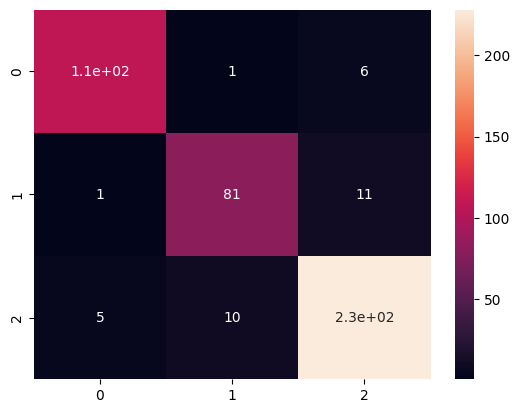

In [38]:
sns.heatmap(confusion_matrix(y_test_encoded,stacking_predictions),annot=True)
plt.show()

### Vision Transformers

#### Vit

In [39]:
import warnings
warnings.filterwarnings('ignore')

In [40]:

class FlexibleViTModel(tf.keras.Model):
    def __init__(self, output_classes):
        super(FlexibleViTModel, self).__init__()
        self.resize = Resizing(224, 224)  # Resize inputs to 224x224
        self.vit_layer = hub.KerasLayer(
            "https://tfhub.dev/sayakpaul/vit_b16_fe/1", 
            trainable=False
        )
        self.flatten = Flatten()
        self.output_dense = Dense(output_classes, activation="softmax")

    def call(self, inputs):
        resized_inputs = self.resize(inputs)
        vit_output = self.vit_layer(resized_inputs)
        vit_output = self.flatten(vit_output)
        return self.output_dense(vit_output)

In [41]:
import os

cache_dir = "D:\\My Laptop\\Me\\Programming\\Machine Learning\\Internships\\Egyptian Space Agency\\Project\\tfhub_cache"
print("Writeable:", os.access(cache_dir, os.W_OK))

import shutil

# Clear the TensorFlow Hub cache
cache_dir = "D:\\My Laptop\\Me\\Programming\\Machine Learning\\Internships\\Egyptian Space Agency\\Project\\tfhub_cache"
shutil.rmtree(cache_dir, ignore_errors=True)
os.makedirs(cache_dir, exist_ok=True)
print("Cache cleared.")

import os

# Set a shorter cache directory
os.environ['TFHUB_CACHE_DIR'] = "d:\\tfhub_cache"
os.makedirs("d:\\tfhub_cache", exist_ok=True)
print("Shortened cache directory set.")



Writeable: True
Cache cleared.
Shortened cache directory set.


In [42]:
# Instantiate the model
input_layer = tf.keras.Input(shape=(128, 128, 3))
output_classes = len(label_encoder)
vit_model = FlexibleViTModel(output_classes)

outputs = vit_model(input_layer)

# Compile the model
final_model = Model(inputs=input_layer, outputs=outputs)
final_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
vit_model.summary()


Model: "flexible_vi_t_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 3)              │         2,307 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,307 (9.01 KB)

 Trainable params: 2,307 (9.01 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor the validation loss
    patience=10,                # Wait for 10 epochs without improvement
    verbose=1,                 # Print a message when stopping
    restore_best_weights=True # Restore the best weights after stopping
)

In [44]:
history = final_model.fit(
    X_train, y_train_encoded, 
    validation_split=0.1, 
    batch_size=32,
    epochs=50,  # Set the maximum number of epochs
    callbacks=[early_stopping]  # Pass the early stopping callback here
)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 331s 6s/step - accuracy: 0.5802 - loss: 0.9945 - val_accuracy: 0.8343 - val_loss: 0.3668
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 280s 5s/step - accuracy: 0.8701 - loss: 0.3631 - val_accuracy: 0.8729 - val_loss: 0.3061
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 272s 5s/step - accuracy: 0.9097 - loss: 0.2743 - val_accuracy: 0.8729 - val_loss: 0.2806
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 285s 6s/step - accuracy: 0.8982 - loss: 0.2608 - val_accuracy: 0.9006 - val_loss: 0.2635
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 287s 6s/step - accuracy: 0.9128 - loss: 0.2397 - val_accuracy: 0.8840 - val_loss: 0.2639
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 288s 6s/step - accuracy: 0.9095 - loss: 0.2205 - val_accuracy: 0.8950 - val_loss: 0.2485
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 288s 6s/step - accuracy: 0.9412 - loss: 0.1847 - val_accuracy: 0.8895 - val_loss: 0.2453
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 290s 6s/step - accuracy: 0.9329 - loss: 0.2027 - val_accuracy: 0.8950 - v

##### Evaluate Vit

In [45]:
train_pred = np.argmax(final_model.predict(X_train),axis=1)
test_probabilities = final_model.predict(X_test) 
test_pred = np.argmax(test_probabilities,axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 343s 6s/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step


In [46]:
Vit_train_accuracy = accuracy_score(y_train_encoded, train_pred)
Vit_test_accuracy = accuracy_score(y_test_encoded, test_pred)

In [47]:
print(f'vit_model train accuracy: {train_accuracy}')
print(f'vit_model test accuracy: {Vit_test_accuracy}')

vit_model train accuracy: 0.9739178419113159
vit_model test accuracy: 0.8957871396895787


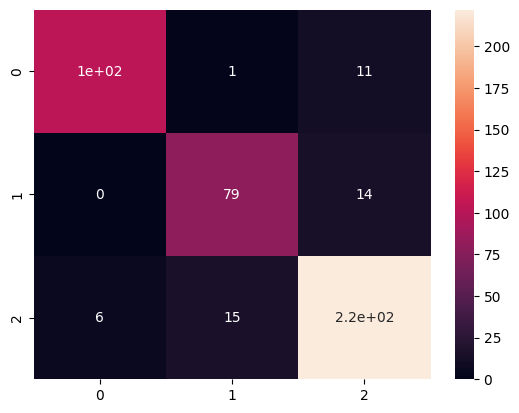

In [48]:
sns.heatmap(confusion_matrix(y_test_encoded,test_pred),annot=True)
plt.show()

In [49]:
final_model.save_weights(r'Weights\vit_model.weights.h5')

#### Swin

In [50]:
class SwinTransformerModel(tf.keras.Model):
    def __init__(self,output_classes):
        super(SwinTransformerModel, self).__init__()
        # Load the Swin Transformer model
        self.resize = Resizing(224, 224)
        self.swin_layer = hub.KerasLayer(
            "https://tfhub.dev/sayakpaul/swin_tiny_patch4_window7_224/1",
            trainable=False  # Set to True for fine-tuning
        )
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(output_classes, activation='softmax')
    
    def call(self, input_tensor):
        resized_inputs = self.resize(input_tensor)
        swin_output = self.swin_layer(resized_inputs)
        swin_output = self.flatten(swin_output)
        return self.dense(swin_output)

In [51]:
input_layer = tf.keras.Input(shape=(128, 128, 3))
swin_model = SwinTransformerModel(output_classes)

output_layer = swin_model(input_layer)

swin_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
swin_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
swin_model.summary()

Model: "functional_168"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_transformer_model          │ (None, 3)              │         3,003 │
│ (SwinTransformerModel)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,003 (11.73 KB)

 Trainable params: 3,003 (11.73 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
history_swin = swin_model.fit(
    X_train, y_train_encoded,
    validation_split=0.1,
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.6083 - loss: 0.9104 - val_accuracy: 0.7790 - val_loss: 0.5765
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8377 - loss: 0.4674 - val_accuracy: 0.8177 - val_loss: 0.4838
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.8696 - loss: 0.3748 - val_accuracy: 0.7403 - val_loss: 0.5276
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8465 - loss: 0.3855 - val_accuracy: 0.8508 - val_loss: 0.4018
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.8856 - loss: 0.3052 - val_accuracy: 0.8122 - val_loss: 0.4298
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.8846 - loss: 0.2945 - val_accuracy: 0.8674 - val_loss: 0.3580
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.9038 - loss: 0.2788 - val_accuracy: 0.8398 - val_loss: 0.3536
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9178 - loss: 0.2722 - val_accuracy: 0.8343 - v

In [53]:
swin_train_pred = np.argmax(swin_model.predict(X_train), axis=1)
swin_test_pred = np.argmax(swin_model.predict(X_test), axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step


In [54]:
swin_train_accuracy = accuracy_score(y_train_encoded, swin_train_pred)
swin_test_accuracy = accuracy_score(y_test_encoded, swin_test_pred)

In [55]:
print(f'swin_model train accuracy: {swin_train_accuracy}')
print(f'swin_model test accuracy: {swin_test_accuracy}')

swin_model train accuracy: 0.8263041065482797
swin_model test accuracy: 0.7827050997782705


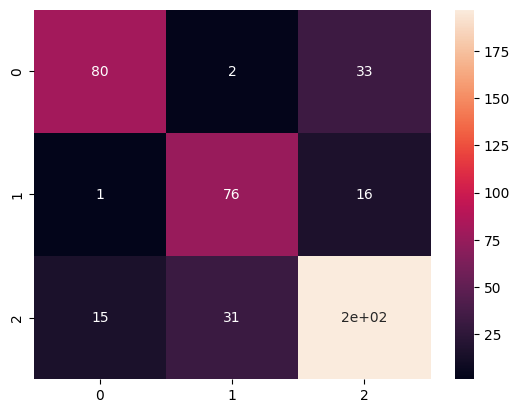

In [56]:
sns.heatmap(confusion_matrix(y_test_encoded, swin_test_pred), annot=True)
plt.show()

In [57]:
swin_model.save_weights(r'Weights\swin_model.weights.h5')

#### ConvNext

In [58]:
class ConvNextModel(tf.keras.Model):
    def __init__(self,output_classes):
        super(ConvNextModel, self).__init__()
        # Load ConvNext from TensorFlow Hub
        self.resize = Resizing(224, 224)
        self.convnext_layer = hub.KerasLayer(
            "https://www.kaggle.com/models/spsayakpaul/convnext/TensorFlow2/base-1k-224/1",
            trainable=False  # Set to True for fine-tuning
        )
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(output_classes, activation='softmax')
    
    def call(self, input_tensor):
        resized_inputs = self.resize(input_tensor)
        convnext_output = self.convnext_layer(resized_inputs)
        convnext_output = self.flatten(convnext_output)
        return self.dense(convnext_output)

In [59]:
input_layer = tf.keras.Input(shape=(128, 128, 3))
convnext_model = ConvNextModel(output_classes)

output_layer = convnext_model(input_layer)

convnext_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
convnext_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
convnext_model.summary()

Model: "functional_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_next_model (ConvNextModel) │ (None, 3)              │         3,003 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,003 (11.73 KB)

 Trainable params: 3,003 (11.73 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
history_convnext = convnext_model.fit(
    X_train, y_train_encoded,
    validation_split=0.1,
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 252s 5s/step - accuracy: 0.5344 - loss: 1.0182 - val_accuracy: 0.7680 - val_loss: 0.6409
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 233s 5s/step - accuracy: 0.7790 - loss: 0.5800 - val_accuracy: 0.7624 - val_loss: 0.5536
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 234s 5s/step - accuracy: 0.8359 - loss: 0.4978 - val_accuracy: 0.7901 - val_loss: 0.5048
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 234s 5s/step - accuracy: 0.8325 - loss: 0.4691 - val_accuracy: 0.7901 - val_loss: 0.4933
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 234s 5s/step - accuracy: 0.8465 - loss: 0.4267 - val_accuracy: 0.8232 - val_loss: 0.4488
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 234s 5s/step - accuracy: 0.8582 - loss: 0.3986 - val_accuracy: 0.8177 - val_loss: 0.4537
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 235s 5s/step - accuracy: 0.8584 - loss: 0.4186 - val_accuracy: 0.8343 - val_loss: 0.4244
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 235s 5s/step - accuracy: 0.8714 - loss: 0.3785 - val_accuracy: 0.8398 - v

In [61]:
convnext_train_pred = np.argmax(convnext_model.predict(X_train), axis=1)
convnext_test_pred = np.argmax(convnext_model.predict(X_test), axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step


In [62]:
convnext_train_accuracy = accuracy_score(y_train_encoded, convnext_train_pred)
convnext_test_accuracy = accuracy_score(y_test_encoded, convnext_test_pred)

In [63]:
print(f'convnext_model train accuracy: {convnext_train_accuracy}')
print(f'convnext_model test accuracy: {convnext_test_accuracy}')

convnext_model train accuracy: 0.781354051054384
convnext_model test accuracy: 0.738359201773836


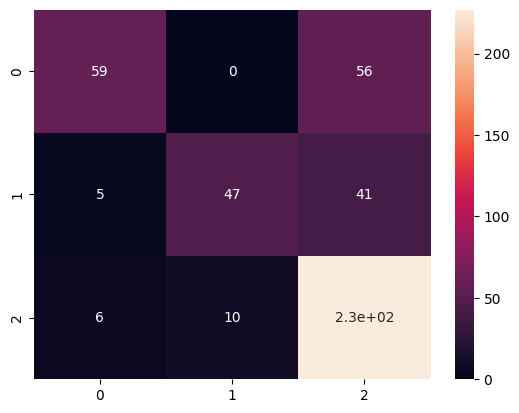

In [64]:
sns.heatmap(confusion_matrix(y_test_encoded, convnext_test_pred), annot=True)
plt.show()

In [65]:
convnext_model.save_weights(r'Weights\convnext_model.weights.h5')

### Compare the Results

In [66]:
# Save final results to CSV
results = {
    'Model': ['CNN', 'Voting', 'Stacking wt LR','Vit','Swin','Convnext'],
    'Test Accuracy': [test_accuracy, ensemble_accuracy, stacking_accuracy,Vit_test_accuracy,swin_test_accuracy,convnext_test_accuracy]
}

In [67]:
results_df = pd.DataFrame(results)
results_df.to_csv('final_results.csv', index=False)